# Models and Results

In this notebook we will be experimenting with different **versions** of our models, **evaluating** their performances and **comparing** the results.

We chose two model architectures: `U-Net`and `DeepLabv3`.

The notebook will have the following structure: 
1. Training `U-Net` on unprocessed data
2. Training `U-Net` on processed data where we only keep the roofs on images 
3. Training `U-Net` on processed data where we only keep the roofs and augment the data 
4. Training `DeepLabv3` on processed data where we only keep the roofs on images

In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import torch
import torch.nn as nn
import albumentations as A
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
from PIL import Image
from albumentations.pytorch import ToTensorV2
from tabulate import tabulate

src_path = Path('../src').resolve()  
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from model import train, predict, evaluate
from dataset import get_loaders
from hyperparameters import optimize_threshold, optimize_unet_hyperparameters
from plotting import plot_prediction, plot_losses, plot_model_metrics
from architectures.unet import UNet

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Importing the data

Let's start by importing the data, you can start by downloading our dataset from [Kaggle](https://www.kaggle.com/datasets/jeanperbet/ml-project-2-solar-panels?select=roof_images) and adding it to the working directory under the folder name `data`.

We will consider three sets of data:
- **Original images** : unmodified 1000 $\times$ 1000 pixel tiles.
- **Roof-only images** : processed 1000 $\times$ 1000 pixel tiles where all non-roof pixels were colored in *magenta*.
- **Labels** : grayscale 1000 $\times$ 1000 pixel tiles encoding the positions of the solar panels.

In [188]:
ROOT_DIR = "../data/"
images_dir = os.path.join(ROOT_DIR, "images/")
roof_images_dir = os.path.join(ROOT_DIR, "roofs/images/")
labels_dir = os.path.join(ROOT_DIR, "labels/")
weights_dir = os.path.join(ROOT_DIR, "weights/")
roof_masks_dir = os.path.join(ROOT_DIR, "roofs/masks/")

image_names = [file.replace(".jpg", "") for file in os.listdir(images_dir) if file.endswith('.jpg')]

### Splitting the data 

In order to evaluate our model well, we will be segmenting our dataset into three subsets: **train set**, **validation set** and **test set**.  Both trainn and validation sets will be used during the training and the test set will be use dofr the final evaluation of the model in order to compute the performance metrics. 

We chose the following split: $80\%$ for train, $10\%$ for validation and $10\%$ for test.

In [104]:
train_transform = ToTensorV2()
val_test_transform = ToTensorV2()
batch_size = 2

images_train_loader, images_val_loader, images_test_loader = get_loaders(
    image_names=image_names[:200],
    images_dir=images_dir, 
    labels_dir=labels_dir, 
    batch_size=batch_size, 
    train_transform=train_transform, 
    val_test_transform=val_test_transform
)
roof_images_train_loader, roof_images_val_loader, roof_images_test_loader = get_loaders(
    image_names=image_names[:200], 
    images_dir=roof_images_dir, 
    labels_dir=labels_dir, 
    batch_size=batch_size,
    train_transform=train_transform,
    val_test_transform=val_test_transform
)
table_data = [["Train", len(images_train_loader) * batch_size],
              ["Validation", len(images_val_loader) * batch_size],
              ["Test", len(images_test_loader) * batch_size]]
print(tabulate(table_data, headers=["Dataset Split", "Number of Images"], tablefmt="fancy_grid"))

╒═════════════════╤════════════════════╕
│ Dataset Split   │   Number of Images │
╞═════════════════╪════════════════════╡
│ Train           │                160 │
├─────────────────┼────────────────────┤
│ Validation      │                 20 │
├─────────────────┼────────────────────┤
│ Test            │                 20 │
╘═════════════════╧════════════════════╛


## Training the models

> In order to accelerate our training, we will be using **early stopping**, which is a regularization technique that halts training when the validation performance stops improving, preventing overfitting to the training data. It monitors the loss after each epoch and stops training if no improvement is observed for a specified number of epochs **(patience)** that we set to $3$ by default. This approach is particularly useful as it balances training duration with model performance.

To ensure that the models are trained on the best available architecture, we eventually move the computations to a GPU.

In [41]:
patience = 3
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: mps


### Step n°1 - Training `U-Net` on regular images

We will start experimenting with the "raw" images, obtained during preprocessing (see notebook `preprocessing.ipynb`).

Before going any further, we need to figure out the best values for the hyperparameters we will use during training. We will compute them once, using `optuna` library. Even if we will add some changes in later steps (i.e. augmenting the data, etc.), we assume that the hyperparameters we'll find now for U-Net on regular images will also be a good fit for later steps, since we will re-use the same model. We now that a further improvement could be fine-tuning hyperparameters each time we modify the training pipeline, but given our time and resources we take this small liberty.

In the detail, we will optimize hyperparameters based on the validation loss for each epoch, i.e. the averaged loss for each data point of our validation set. We would like to find the best values for the **learning rate**, **the number of epochs**, the **kernel size** of our encoder and the **number of layers** in our U-Net encoder/decoder. The code is available in `src/hyperparameters.py`.

> Due to the long running time of such an optimization, we comment out the hyperparameters optimization and already provide them. If you have some time though, you can uncomment the hyperparameters optimizaiton to have an idea of the hyperparameters importances ! 

In [118]:
nb_layers, kernel_size, lr, epochs = 3, 5, 3e-4, 50
# best_params = optimize_unet_hyperparameters(train_loader=images_train_loader, val_loader=images_val_loader, n_trials=2, device=device)
# nb_layers, kernel_size, lr, epochs = best_params["encoder_layers"], best_params["kernel_size"], best_params["lr"], best_params["epochs"]

Time to train the model ! The following cell will use the previously-computed best hyperparameters to train a U-Net model on the images of our dataset.

> Due to the long running time of such a training, we comment out the training phase and we already provide the weights for our pre-trained model, in the `data/weights` folder. If you have some time though, you can uncomment the training  code and run it yourself !   

In [107]:
step_1_model = UNet(nb_layers=nb_layers, kernel_size=kernel_size)
if device != "cuda":
    step_1_model.load_state_dict(torch.load(os.path.join(weights_dir, "unet_step_1_weights.pth"), map_location=torch.device('cpu')))
else:
    step_1_model.load_state_dict(torch.load(os.path.join(weights_dir, "unet_step_1_weights.pth")))
step_1_model.to(device);

# step_1_train_losses, step_1_val_losses = train_model(
#     model=step_1_model,
#     train_loader=images_train_loader,
#     val_loader=images_val_loader,
#     device=device,
#     criterion=nn.BCELoss(),
#     lr=lr,
#     epochs=epochs,
#     patience=patience
# )
# plot_losses(step_1_train_losses, step_1_val_losses)

Now that our model is trained, we have another important value to figure out. Indeed, our model outputs probabilities for each pixel of the input image of being part of a solar panel. We need to determine the most optimal probability **threshold** above which we classify a pixel as `solar_panel` or not. Following a similar reasoning as for hyperparameters, we will use `optuna` to determine the threshold maximizing both **IoU** and **F1-Score**.

> Due to the long running time of the threshold optimization, we already provide it. But again, feel free to run the code yourself by uncommenting the relevant parts in the cell below !

In [137]:
step_1_threshold = 0.12
# step_1_threshold = optimize_threshold(model=step_1_model, test_loader=images_test_loader, n_trials=20, device=device)

Now, let's visualize some of the results. We will always use the same image throughout this notebook, in order to have a better understanding of the progress we make at each step. We'll use the index n°$0$ in our test loader for comparison purposes.

In [233]:
test_idx = 0

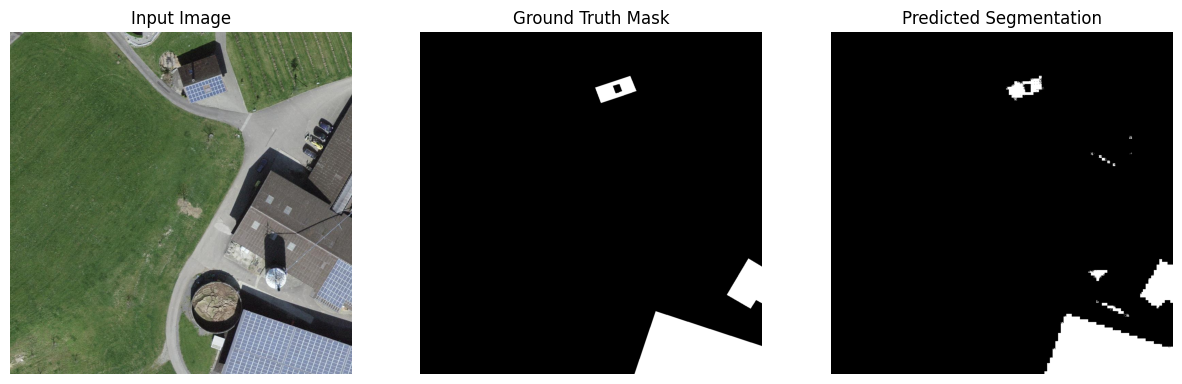

In [238]:
real_image, ground_truth, prediction = predict(
    model=step_1_model, 
    test_loader=images_test_loader,
    idx=test_idx, 
    threshold=step_1_threshold,
    device=device
)
plot_prediction(real_image, ground_truth, prediction)

The results are not so bad ! We can notice three interesting mistakes from the model, that we may be able to correct using some **post-processing**.

1. Firstly, the output images contain some clusters of **noisy dots** that are **too small** to be real solar panels. We could try analysing the connected components in the model output to remove the ones below a certain threshold. 

2. Secondly, solar panels tend to have **straight edges**, whereas the model sometimes output messy non-regular edges. We could smooth the edges to try to match real-world patterns. 

3. Finally, some pixels outside of roofs (such as shadows for instance) are wrongly interpreted by the model as being solar panels. We have the necessary data (see `preprocessing.ipynb`) to **mask out non-roof areas**, that's why we could try setting all pixels that are outside of roofs in the model output to $0$, i.e. non-`solar_panel`.

All the code to perform these post-processing operatins is available in `src/postprocessing.py`. Let's apply all these operations and visualize the results again.

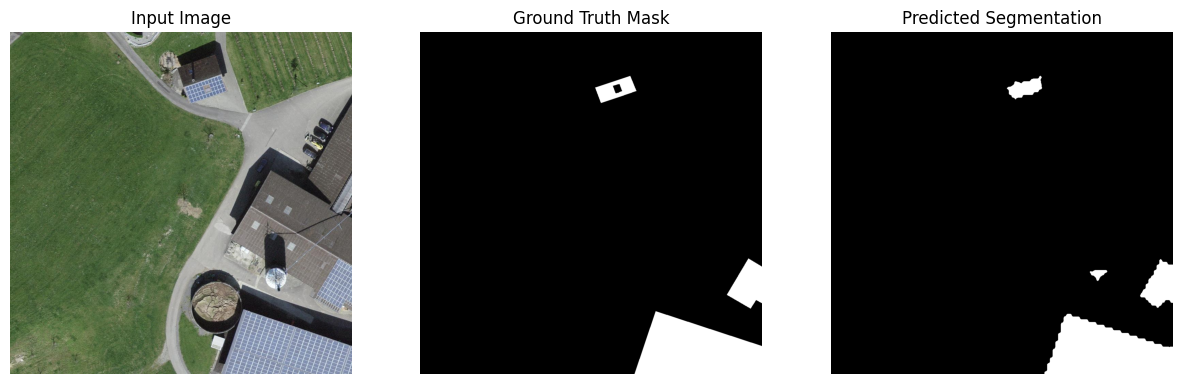

In [256]:
real_image, ground_truth, prediction = predict(
    model=step_1_model, 
    test_loader=images_test_loader,
    idx=test_idx, 
    threshold=step_1_threshold,
    post_process=True,
    roof_masks_dir=roof_masks_dir,
    device=device,
)
plot_prediction(real_image, ground_truth, prediction)

We can also evaluate our model more rigorously using the following metrics: **accuracy**, **IoU** and **F1-Score**. The former is the intersection over union (also known as [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index)), and is defined as follows.
$$ 
\text{IoU} = \frac{\text{TP}}{\text{TP} + \text{FP} + \text{FN}}
$$

The latter is defined as follows.
$$ 
\text{F1-Score} = \frac{2}{(\frac{1}{\text{Precision}} + \frac{1}{\text{Recall}})}
$$

In [257]:
step_1_accuracy, step_1_f1, step_1_iou = (
    evaluate(
        model=step_1_model, 
        test_loader=images_test_loader, 
        threshold=step_1_threshold, 
        device=device
    )
)
table_data = [["Accuracy", step_1_accuracy],
              ["F1-Score", step_1_f1],
              ["IoU", step_1_iou]]
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt="fancy_grid"))

Evaluating on test set: 100%|██████████| 20/20 [00:08<00:00,  2.49it/s]

tp: 103637, tn: 19720234, fp: 121093, fn: 55036
╒══════════╤══════════╕
│ Metric   │    Value │
╞══════════╪══════════╡
│ Accuracy │ 0.991194 │
├──────────┼──────────┤
│ F1-Score │ 0.540617 │
├──────────┼──────────┤
│ IoU      │ 0.370442 │
╘══════════╧══════════╛


Let's compare these metrics with the same ones obtained when post-processing the data.

In [265]:
step_1_post_accuracy, step_1_post_f1, step_1_post_iou = (
    evaluate(
        model=step_1_model, 
        test_loader=images_test_loader, 
        threshold=step_1_threshold, 
        post_process=True,
        roof_masks_dir=roof_masks_dir,
        device=device
    )
)
table_data = [["Accuracy", step_1_post_accuracy],
              ["F1-Score", step_1_post_f1],
              ["IoU", step_1_post_iou]]
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt="fancy_grid"))

Evaluating on test set: 100%|██████████| 20/20 [00:10<00:00,  1.96it/s]

╒══════════╤══════════╕
│ Metric   │    Value │
╞══════════╪══════════╡
│ Accuracy │ 0.992326 │
├──────────┼──────────┤
│ F1-Score │ 0.546547 │
├──────────┼──────────┤
│ IoU      │ 0.376033 │
╘══════════╧══════════╛


We can observe minor improvements using post-processing. However, we see some potential into removing the non-roof pixels from the output of our model. In the next steps, we'll try a different approach by removing non-roof parts of images directly before training instead of during post-processing.

### Step n°2 - Training `U-Net` on roof-only images

In this second step, as stated above, we'll try to reduce the complexity of the data before feeding it the model. Our assumption is that **solar panels can only lie on roofs**. Hence, we decided to color every pixel that does not lie on a roof using **magenta** (see notebook `preprocessing.ipynb` for further explanations). This way, we make the model focus more on the roof-based pixels. The images we'll use from now on look like the following.

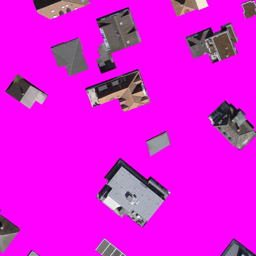

In [121]:
Image.open(os.path.join(roof_images_dir, image_names[1] + ".jpg")).resize((256, 256))

Following the same reasoning as above, we provide the commented training code as well as the pre-trained model. Feel free to train the model yourself instead of loading the weights we provide !

In [141]:
step_2_model = UNet(nb_layers=nb_layers, kernel_size=kernel_size)
if device != "cuda":
    step_2_model.load_state_dict(torch.load(os.path.join(weights_dir, "unet_step_1_weights.pth"), map_location=torch.device('cpu')))
else:
    step_2_model.load_state_dict(torch.load(os.path.join(weights_dir, "unet_step_1_weights.pth")))
step_2_model.to(device);

# step_2_train_losses, step_2_val_losses = train_model(
#     model=step_2_model,
#     train_loader=roof_images_train_loader,
#     val_loader=roof_images_val_loader,
#     device=device,
#     criterion=nn.BCELoss(),
#     lr=lr,
#     epochs=epochs,
#     patience=patience
# )
# plot_losses(step_2_train_losses, step_2_val_losses)

step_2_threshold = 0.12
# step_2_threshold = optimize_threshold(model=step_2_model, test_loader=roof_images_test_loader, n_trials=20, device=device)

Let's visualize our results on the same image used for step n°1, to see if it yields an improvement.

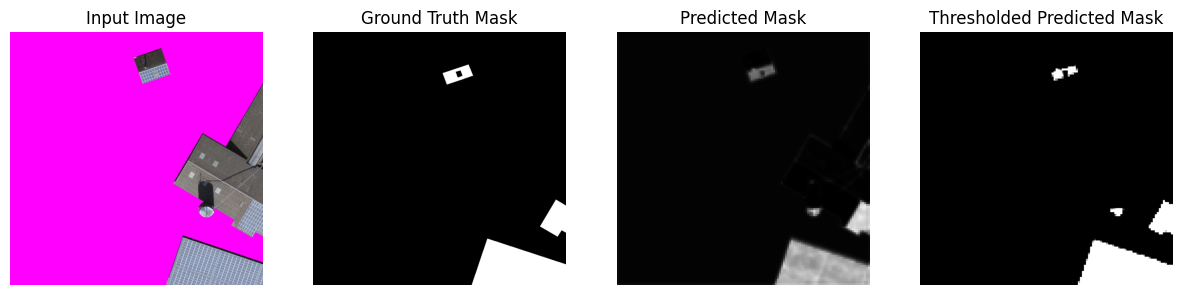

In [ ]:
real_image, ground_truth, prediction = predict(
    model=step_2_model, 
    test_loader=roof_images_test_loader,
    idx=test_idx, 
    threshold=step_2_threshold,
    device=device,
)
plot_prediction(real_image, ground_truth, prediction)

Let's also compute more accurate metrics.

In [174]:
step_2_accuracy, step_2_f1, step_2_iou = (
    evaluate(model=step_2_model, test_loader=roof_images_test_loader, threshold=step_2_threshold, device=device)
)
table_data = [["Accuracy", step_2_accuracy],
              ["F1-Score", step_2_f1],
              ["IoU", step_2_iou]]
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt="fancy_grid"))

╒══════════╤══════════╕
│ Metric   │    Value │
╞══════════╪══════════╡
│ Accuracy │ 0.99252  │
├──────────┼──────────┤
│ F1-Score │ 0.562329 │
├──────────┼──────────┤
│ IoU      │ 0.391139 │
╘══════════╧══════════╛


### Step n°3 - Training `U-Net` on rotation-augmented, roof-only images

During this step, we'll try to improve the performance of our model with some **data augmentation**. This will simulate some **realistic inputs** the model might encounter with new data. We'll be using the library [`albumentations`](https://albumentations.ai), which allows to apply transforms with a probability $p$ on both images and their labels during the training phase.

We'll be transforming our original data using a composition of **rotations** (using a uniformly random chosen angle between $0°$, $90°$, $180°$ and $270°$), and **symmetries** around both the $x$-axis and $y$-axis.

In [152]:
train_transform = A.Compose([
        A.OneOf([
                A.Rotate(limit=(0, 0), p=0.25),
                A.Rotate(limit=(90, 90), p=0.25),
                A.Rotate(limit=(180, 180), p=0.25),
                A.Rotate(limit=(270, 270), p=0.25),
            ], p=1.0,
        ),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
    ],
    is_check_shapes=False,
)
roof_images_train_loader.transform = train_transform


Following the same reasoning as above, we provide the commented training code as well as the pre-trained model. Feel free to train the model yourself instead of loading the weights we provide !

In [166]:
step_3_model = UNet(nb_layers=nb_layers, kernel_size=kernel_size)
if device != "cuda":
    step_3_model.load_state_dict(torch.load(os.path.join(weights_dir, "unet_step_1_weights.pth"), map_location=torch.device('cpu')))
else:
    step_3_model.load_state_dict(torch.load(os.path.join(weights_dir, "unet_step_1_weights.pth")))
step_3_model.to(device);

# step_3_train_losses, step_3_val_losses = train_model(
#     model=step_3_model,
#     train_loader=roof_images_train_loader,
#     val_loader=roof_images_val_loader,
#     device=device,
#     criterion=nn.BCELoss(),
#     lr=lr,
#     epochs=epochs,
#     patience=patience
# )
# plot_losses(step_3_train_losses, step_3_val_losses)

step_3_threshold = 0.12
# step_3_threshold = optimize_threshold(model=step_3_model, test_loader=roof_images_test_loader, n_trials=20, device=device)

And again, we visualize the results !

In [266]:
plot_prediction(step_3_model, roof_images_test_loader, idx=0, device=device, threshold=step_3_threshold)

TypeError: plot_prediction() got an unexpected keyword argument 'idx'

Finally, we compute our metrics.

In [168]:
step_3_accuracy, step_3_f1, step_3_iou = (
    evaluate(model=step_3_model, test_loader=roof_images_test_loader, threshold=step_3_threshold, device=device)
)
table_data = [["Accuracy", step_3_accuracy],
              ["F1-Score", step_3_f1],
              ["IoU", step_3_iou]]
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt="fancy_grid"))

╒══════════╤══════════╕
│ Metric   │    Value │
╞══════════╪══════════╡
│ Accuracy │ 0.99252  │
├──────────┼──────────┤
│ F1-Score │ 0.562329 │
├──────────┼──────────┤
│ IoU      │ 0.391139 │
╘══════════╧══════════╛


## Comparing results

For the final comparison of  our models we will be primarily focusing in `F1-score` and `IoU`. Let's start by visualizing these results susing bar plots.

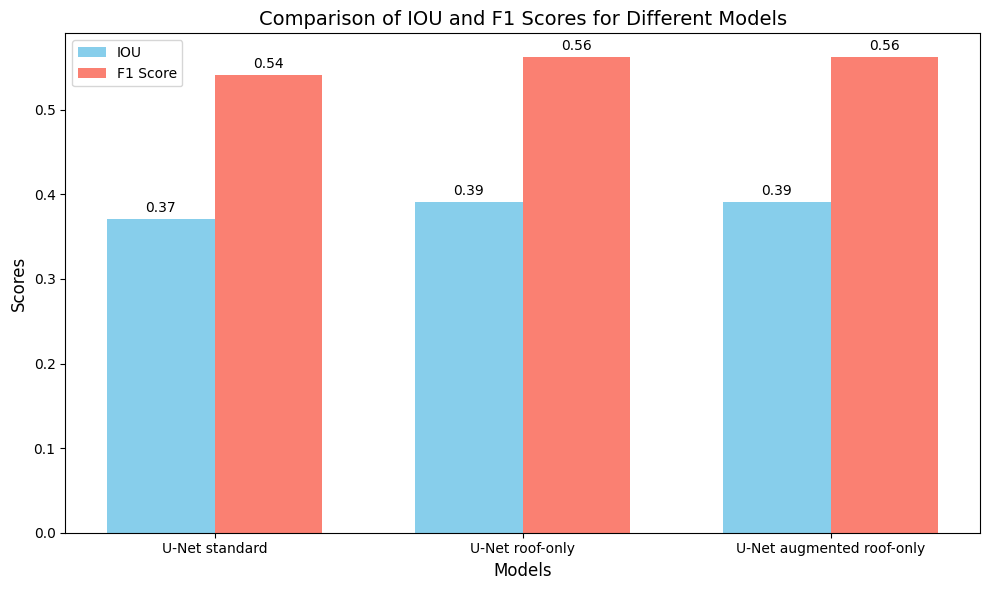

In [175]:
models = ['U-Net standard', 'U-Net roof-only', 'U-Net augmented roof-only']
ious = [step_1_iou, step_2_iou, step_3_iou]
f1_scores = [step_1_f1, step_2_f1, step_3_f1]

plot_model_metrics(models, ious, f1_scores)